In [10]:
!pip install neattext

     |████████████████████████████████| 114 kB 16.3 MB/s            


In [55]:
import pandas as pd 
import numpy as np 
import string
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
%matplotlib inline 
sns.set(color_codes=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [93]:
from sklearn.multiclass import OneVsRestClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## 1. Data Exploration

In [94]:
data = pd.read_csv('data/data.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Text(0.5, 0, '# of categories')

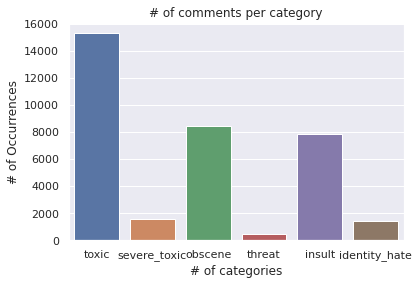

In [99]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 
      'insult', 'identity_hate']
labels_data = data[labels]
label_count = labels_data.sum()
ax = sns.barplot(label_count.index, label_count.values)
plt.title("# of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [58]:
# test_data = pd.read_csv('data/test.csv')
# test_labels = pd.read_csv('data/test_labels.csv')

The below figure shows the dir

Text(0.5, 0, '# of categories')

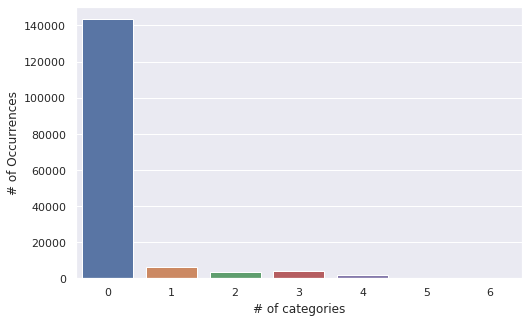

In [59]:
# classified = data[
#     (data['toxic'] != 0) | 
#     (data['severe_toxic'] == 0) | 
#     (data['obscene'] != 0) | 
#     (data['threat'] != 0) | 
#     (data['insult'] !=0) | 
#     (data['identity_hate'] !=0)
#          ]
# not_classifid = data[
#     (data['toxic'] == 0) & 
#     (data['severe_toxic'] == 0) & 
#     (data['obscene'] == 0) & 
#     (data['threat'] == 0) & 
#     (data['insult'] == 0) & 
#     (data['identity_hate'] == 0)
#          ]
# print(type(classified))
# print(type(not_classifid))
# df = pd. concat([not_classifid, classified], axis=1) 

rowsums = data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

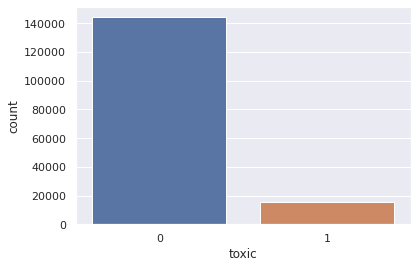

In [60]:
g = sns.countplot(data['toxic'])
plt.show()

In [61]:
def plot_data(): 
    barWidth = 0.35
    plt.figure(figsize=(8,5))
    bars1 = [sum(data['toxic'] == 1), sum(data['severe_toxic'] == 1), sum(data['obscene'] == 1), sum(data['threat'] == 1),
             sum(data['insult'] == 1), sum(data['identity_hate'] == 1)]
    bars2 = [sum(data['toxic'] == 0), sum(data['severe_toxic'] == 0), sum(data['obscene'] == 0), sum(data['threat'] == 0),
             sum(data['insult'] == 0), sum(data['identity_hate'] == 0)]

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, bars1, color='steelblue', width=barWidth, label='classified')
    plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='not_classified')

    plt.xlabel('categories')
    plt.ylabel('# of comments')
    plt.xticks([r + barWidth for r in range(len(bars1))], labels)

    plt.legend()
    plt.show()
    pass 

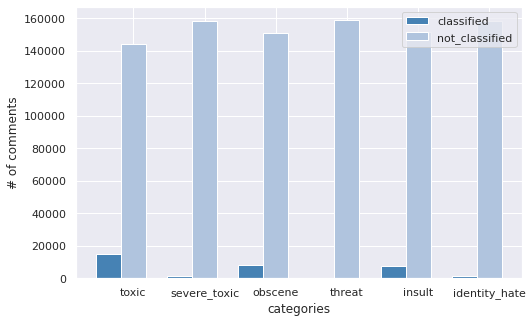

In [62]:
plot_data()

The plot above shows that there is an imbalance dataset. So, to address this issue we will need to drop data that does not fall into any category

In [98]:
data.drop('id', axis=1, inplace=True)
data.drop(data[
    (data['toxic'] == 0) & 
    (data['severe_toxic'] == 0) & 
    (data['obscene'] == 0) & 
    (data['threat'] == 0) & 
    (data['insult'] == 0) & 
    (data['identity_hate'] == 0)
         ].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [64]:
# plot_data()

In [65]:
data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
1,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
2,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
3,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
4,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...
16220,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
16221,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
16222,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
16223,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [95]:
import neattext.functions as nfx

import re
from bs4 import BeautifulSoup

def preprocess_text(data):
    text = BeautifulSoup(data, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text.lower()) # Convert to lower case
    words = nfx.remove_stopwords(text)

    return words

In [96]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [68]:
preprocess_text(data['comment_text'][0])

'cocksucker piss work'

In [97]:
data['comment_text'] = data['comment_text'].apply(preprocess_text)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http:

In [70]:
data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,cocksucker piss work,1,1,1,0,1,0
1,hey talk exclusive group wp talibans good dest...,1,0,0,0,0,0
2,bye look come think comming tosser,1,0,0,0,0,0
3,gay antisemmitian archangel white tiger meow g...,1,0,1,0,1,1
4,fuck filthy mother ass dry,1,0,1,0,1,0
...,...,...,...,...,...,...,...
16220,previous conversation fucking shit eating libe...,1,0,1,0,1,1
16221,mischievious pubic hair,1,0,0,0,1,0
16222,absurd edits absurd edits great white shark to...,1,0,1,0,1,0
16223,hey listen delete edits annoyed wwe k roster c...,1,0,0,0,1,0


In [71]:
data.to_csv('model_data/train.csv', index=False, header=False)

In [103]:
train = data.copy()
data = pd.read_csv('data/test.csv')
data_labels = pd.read_csv('data/test_labels.csv')

In [73]:
data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [74]:
data_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [104]:
drop_index = data_labels[
    (data_labels['toxic'] == -1) | 
    (data_labels['severe_toxic'] == -1) | 
    (data_labels['obscene'] == -1) | 
    (data_labels['threat'] == -1) | 
    (data_labels['insult'] == -1) | 
    (data_labels['identity_hate'] == -1)
]['id']

# data.drop(drop_index.id, axis=0, inplace=True)
# data_labels.drop(drop_index.id, axis=0, inplace=True)
# new_df = sales[~sales.CustomerID.isin(badcu)]
data = data[~data.id.isin(drop_index)]
data_labels = data_labels[~data_labels.id.isin(drop_index)]

In [76]:
data

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very high...
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."
...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ..."
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...


In [77]:
data_labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,0,0,0,0,0,0
153151,fff9d70fe0722906,0,0,0,0,0,0
153154,fffa8a11c4378854,0,0,0,0,0,0
153155,fffac2a094c8e0e2,1,0,1,0,1,0


In [78]:
# drop_index = data_labels[
#     (data_labels['toxic'] == 0) & 
#     (data_labels['severe_toxic'] == 0) & 
#     (data_labels['obscene'] == 0) & 
#     (data_labels['threat'] == 0) & 
#     (data_labels['insult'] == 0) & 
#     (data_labels['identity_hate'] == 0)
#            ].index
# data = data[~data.index.isin(drop_index)]
# data_labels = data_labels[~data_labels.index.isin(drop_index)]

In [79]:
# data

In [80]:
# data_labels

In [105]:
data.drop('id', axis=1, inplace=True)
data_labels.drop('id', axis=1, inplace=True)

In [106]:
data['comment_text'] = data['comment_text'].apply(preprocess_text)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Half-Life_%28series%29" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://es.wikipedia.org/wiki/Usuario_Discusi%C3%B3n:Sarah_W." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/bs4/__init__.py:424: MarkupResemblesLocatorWarning: "http://en.wikipedia.org/wiki/Rayleigh%E2%80%93B%C3%A9nard_convection" looks like a U

In [83]:
data

,comment_text
5,thank understanding think highly revert discus...
7,dear god site horrible
11,somebody invariably try add religion mean way ...
13,says right type type institution needed case l...
14,adding new product list sure relevant adding n...
...,...
153150,jerome got surprised looked example nomine pla...
153151,lucky bastard http wikimediafoundation org wik...
153154,shame want speak gays romanians
153155,mel gibson nazi bitch makes shitty movies butt...


In [84]:
data.to_csv('model_data/test_x.csv', index=False, header=False)
data_labels.to_csv('model_data/test_y.csv', index=False, header=False)

In [85]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

prefix = 'toxic_comments'

train_path = sagemaker_session.upload_data('model_data', bucket=bucket, key_prefix=prefix)

In [86]:
from sagemaker.sklearn.estimator import SKLearn
estimator = SKLearn(sagemaker_session=sagemaker_session,
                    entry_point='train_binR.py',
                    source_dir='model/',
                    role=role, 
                    instance_type='ml.m5.2xlarge',
                    framework_version='0.23-1')

In [91]:
%%time

# Train your estimator on S3 training data
estimator.fit(train_path)

2022-02-03 22:20:37 Starting - Starting the training job...ProfilerReport-1643926837: InProgress
...
2022-02-03 22:21:31 Starting - Launching requested ML instances......
2022-02-03 22:22:31 Starting - Preparing the instances for training.........
2022-02-03 22:23:51 Downloading - Downloading input data...
2022-02-03 22:24:39 Training - Training image download completed. Training in progress.
2022-02-03 22:24:39 Uploading - Uploading generated training model
2022-02-03 22:24:39 Failed - Training job failed
2022-02-03 22:24:26,623 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-02-03 22:24:26,626 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-03 22:24:26,636 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-02-03 22:24:34,199 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-03 22:24:34,211 sagemaker-training-toolkit INFO     No 

UnexpectedStatusException: Error for Training job sagemaker-scikit-learn-2022-02-03-22-20-37-083: Failed. Reason: AlgorithmError: framework error: 
Traceback (most recent call last):
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_containers/_trainer.py", line 84, in train
    entrypoint()
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_sklearn_container/training.py", line 39, in main
    train(environment.Environment())
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_sklearn_container/training.py", line 35, in train
    runner_type=runner.ProcessRunnerType)
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_training/entry_point.py", line 100, in run
    wait, capture_error
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_training/process.py", line 161, in run
    cwd=environment.code_dir,
  File "/miniconda3/lib/python3.7/site-packages/sagemaker_training/process.py", line 81, in check_error
    raise error_class(return_code=return_code, cmd=" ".join(cmd), output=stderr)
sagemaker_training.errors.ExecuteUserScriptError: ExecuteUserScriptError:
Command "/miniconda3/bin/python 

In [90]:
for x in range(1, 7):
    print(x)

1
2
3
4
5
6


In [33]:
%%time

predictor = estimator.deploy(
    initial_instance_count = 1, 
    instance_type='ml.m5.2xlarge'
)

ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Could not find model data at s3://sagemaker-us-east-1-745885361571/sagemaker-scikit-learn-2022-02-03-20-21-08-327/output/model.tar.gz.

In [41]:
df = pd.read_csv('model_data/train.csv')
vector = TfidfVectorizer()
comment = df.iloc[:, 0]
features = vector.fit_transform(comment.apply(lambda x: np.str_(x))).toarray()

In [45]:
!pip install scikit-multilearn
from sklearn.svm import SVC
from skmultilearn.problem_transform import BinaryRelevance
train_y = df.iloc[:, 1:]
model = BinaryRelevance(
            classifier = SVC(),
            require_dense = [False, True]
        )
model.fit(features, train_y)

TypeError: no supported conversion for types: (dtype('O'),)

In [47]:
features.toarray()

MemoryError: Unable to allocate 190. GiB for an array with shape (159570, 159570) and data type float64

In [100]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [107]:
X_test = data['comment_text']
test = data_labels

In [109]:
X_train = train['comment_text']
for category in labels:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))



... Processing toxic
Test accuracy is 0.09518897120885304
... Processing severe_toxic
Test accuracy is 0.9942636531307637
... Processing obscene
Test accuracy is 0.7931007533839758
... Processing threat
Test accuracy is 0.9967019913095126
... Processing insult
Test accuracy is 0.9100003126074588
... Processing identity_hate
Test accuracy is 0.9888711744662227
